# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from dotenv import load_dotenv
import warnings

In [ ]:
from src.load_results import (
    create_norm_metrics_dataframe,
    create_sharpness_metrics_dataframe,
    create_performance_metrics_dataframe,
    create_ood_performance_metrics_dataframe,
    create_performance_gap_dataframes,
    create_train_val_gap_dataframe,
)

In [ ]:
from src.visualization import (
    set_academic_style,
    visualize_test_set_histograms,
    visualize_test_set_scatter,
    plot_correlation_matrix,
    plot_pairplot,
    dataframe_pairwise_correlation,
)

set_academic_style()

In [5]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")
RESULTS_DIR = os.getenv("RESULTS_DIR")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [ ]:
from src.model_constructor import models_iterator

depths = [2, 4]
filters_sizes = {
    "2": [[8, 16, 160, 80], [32, 64, 320, 160]],
    "4": [[4, 8, 16, 32, 200, 200, 160, 80], [8, 16, 32, 64, 400, 320, 160, 80]],
}
lrs = [0.01, 0.001, "scheduler"]
drops = {"2": [[0.0, 0.0], [0.5, 0.2]], "4": [[0.0] * 4, [0.5, 0.3, 0.3, 0.2]]}
optimizers = ["adam", "sgd"]
models_to_train = models_iterator(depths, filters_sizes, optimizers, drops, lrs)

In [7]:
test_sets = [
    "test_101",
    "test_10c1",
    "test_10c2",
    "test_10c3",
    "test_10c4",
    "test_10c5",
    "fgsm",
    "pgd",
    "cw",
    "deepfool",
    "bim",
]
norms_df = create_norm_metrics_dataframe(models_to_train)
sharpness_df = create_sharpness_metrics_dataframe(models_to_train)
performance_df = create_performance_metrics_dataframe(models_to_train)
train_val_gap_df = create_train_val_gap_dataframe(models_to_train)

ood_performance_df = create_ood_performance_metrics_dataframe(models_to_train, test_sets)
performance_gap_df, proportional_performance_gap_df = create_performance_gap_dataframes(
    models_to_train, test_sets
)

In [8]:
norms_df.to_csv(f"{RESULTS_DIR}/norms.csv", index=False)
sharpness_df.to_csv(f"{RESULTS_DIR}/sharpness.csv", index=False)
performance_df.to_csv(f"{RESULTS_DIR}/performance.csv", index=False)
train_val_gap_df.to_csv(f"{RESULTS_DIR}/train_val_gap.csv", index=False)
ood_performance_df.to_csv(f"{RESULTS_DIR}/ood_performance.csv", index=False)
performance_gap_df.to_csv(f"{RESULTS_DIR}/performance_gap.csv", index=False)
proportional_performance_gap_df.to_csv(f"{RESULTS_DIR}/proportional_performance_gap.csv", index=False)

# 1. Univariate Visualization

### 1.1 Histogram - Visualize OOD Test Values 

In [ ]:
pd.set_option("display.max_rows", 999)
ood_performance_df[
    [col for col in ood_performance_df.columns if "accuracy" in col and "top5" not in col]
].describe().T

Figure saved to reports/figures/test_accuracy_histograms.pdf


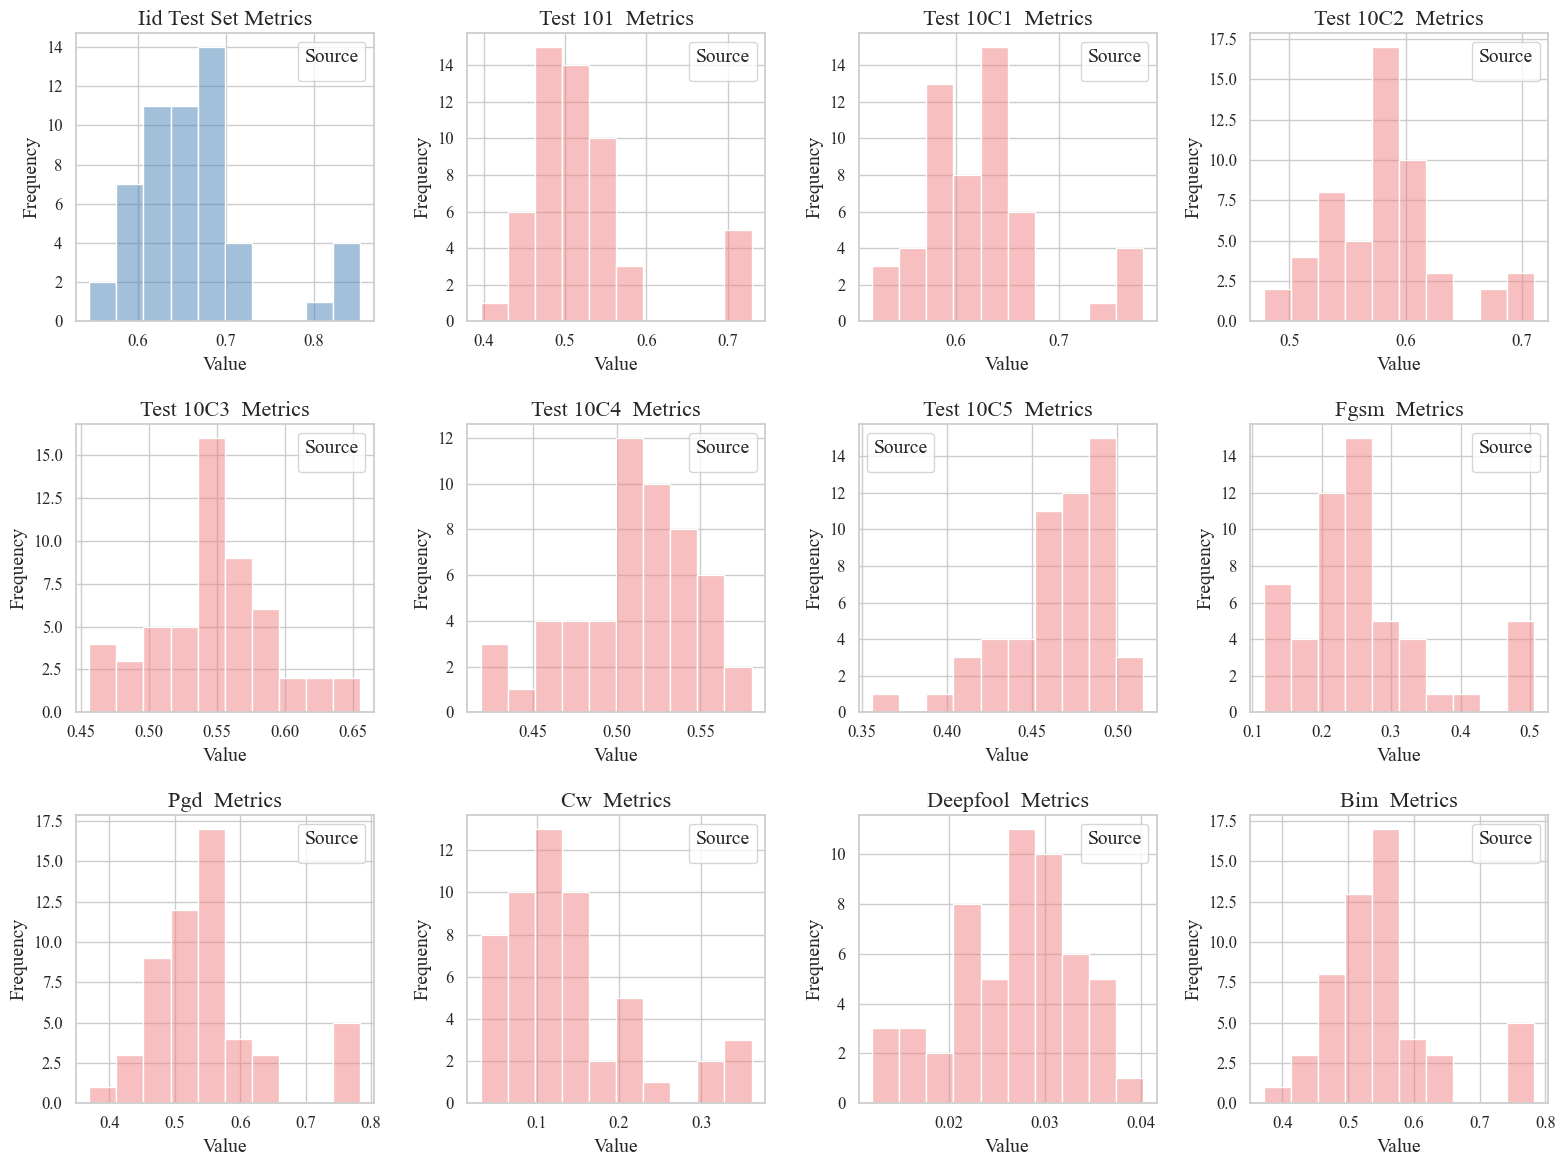

In [ ]:
visualize_test_set_histograms(
    performance_df, ood_performance_df, "accuracy", save_path="reports/figures/test_accuracy_histograms.pdf"
)

In [ ]:
pd.set_option("display.max_rows", 999)
ood_performance_df[
    [col for col in ood_performance_df.columns if "log_loss" in col and "top5" not in col]
].describe().T

In [ ]:
visualize_test_set_histograms(performance_df, ood_performance_df, "log_loss")

### 1.2 Histogram - Visualize ODD Test Gap Values

In [ ]:
pd.set_option("display.max_rows", 999)
performance_gap_df[
    [col for col in performance_gap_df.columns if "accuracy" in col and "top5" not in col]
].describe().T

In [ ]:
visualize_test_set_histograms(performance_df, performance_gap_df, "accuracy")

In [ ]:
pd.set_option("display.max_rows", 999)
performance_gap_df[
    [col for col in performance_gap_df.columns if "log_loss" in col and "top5" not in col]
].describe().T

In [ ]:
visualize_test_set_histograms(performance_df, performance_gap_df, "log_loss")

### 1.3 Histogram - Visualize OOD Proportional Test Gap Values

In [ ]:
pd.set_option("display.max_rows", 999)
proportional_performance_gap_df[
    [col for col in proportional_performance_gap_df.columns if "log_loss" in col and "top5" not in col]
].describe().T

In [ ]:
visualize_test_set_histograms(performance_df, proportional_performance_gap_df, "accuracy")

In [ ]:
visualize_test_set_histograms(performance_df, proportional_performance_gap_df, "log_loss")

# 2. Multivariate Visualizations

### 2.1 Multivariate - OOD Test Sets Values

In [21]:
IMAGES_DIR = "reports/figures"

#### Accuracy

Figure saved to reports/figures/scatter_iid_ood_accuracy.pdf


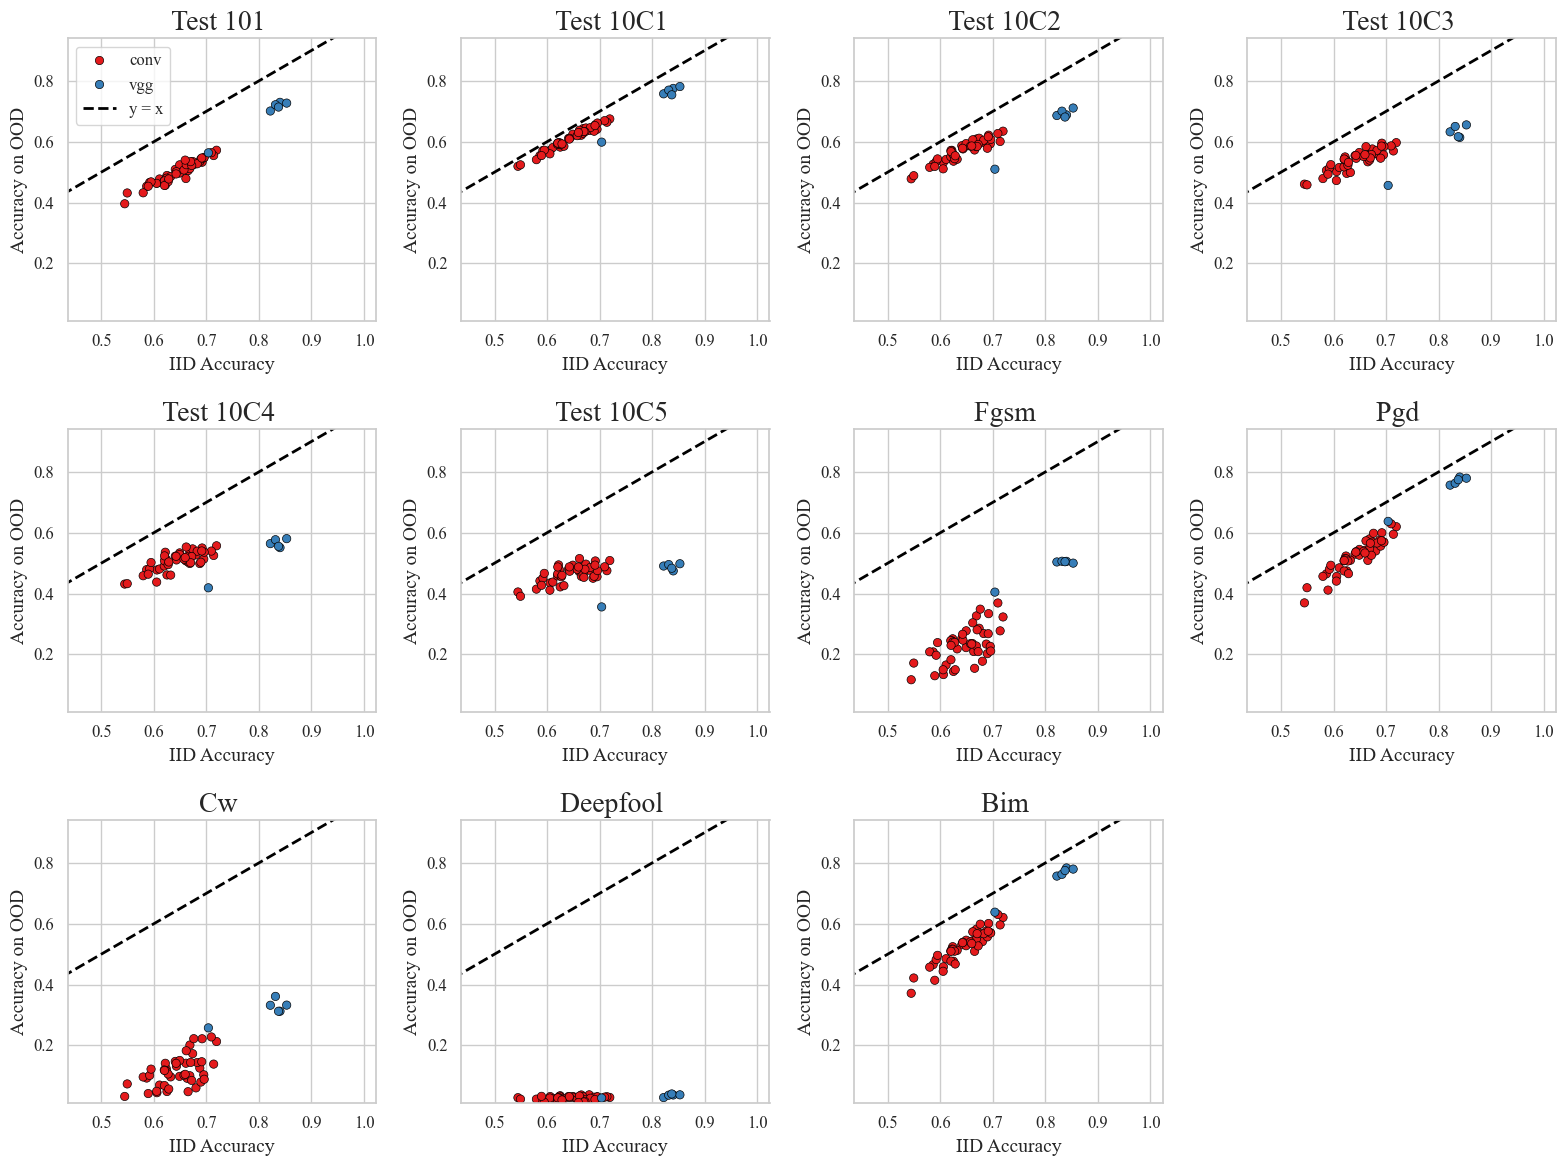

In [59]:
visualize_test_set_scatter(
    iid_df=performance_df,
    ood_df=ood_performance_df,
    iid_metric="accuracy",  # Use the exact column name for IID accuracy
    ood_metric_prefix="accuracy",  # Prefix for OOD columns
    title_suffix="Accuracy",
    ood_label="Accuracy on OOD",
    baseline_line=True,
    save_path=f"{IMAGES_DIR}/scatter_iid_ood_accuracy.pdf",
)

In [ ]:
plot_correlation_matrix(
    pd.concat([ood_performance_df, performance_df], axis=1),
    metric_prefix="accuracy",
    corr_type="kendall",
    title="Accuracy Correlation Matrix",
)

In [ ]:
cols = [col for col in ood_performance_df.columns if "accuracy" in col and "top5" not in col]
plot_pairplot(ood_performance_df[cols])

#### Log-Loss

In [ ]:
visualize_test_set_scatter(
    iid_df=performance_df,
    ood_df=ood_performance_df,
    iid_metric="log_loss",  # Use the exact column name for IID log_loss
    ood_metric_prefix="log_loss",  # Prefix for OOD columns
    title_suffix="Log-Loss",
    ood_label="Log-Loss on OOD",
)

In [ ]:
plot_correlation_matrix(
    pd.concat([ood_performance_df, performance_df], axis=1),
    metric_prefix="log_loss",
    corr_type="kendall",
    title="Log-Loss Correlation Matrix",
)

In [ ]:
cols = [col for col in ood_performance_df.columns if "log_loss" in col]
plot_pairplot(ood_performance_df[cols])

### 2.2 Multivariate - OOD Test Gap Values

#### Accuracy

Figure saved to reports/figures/correlation_shift_corruptions_accuracy_gap.pdf


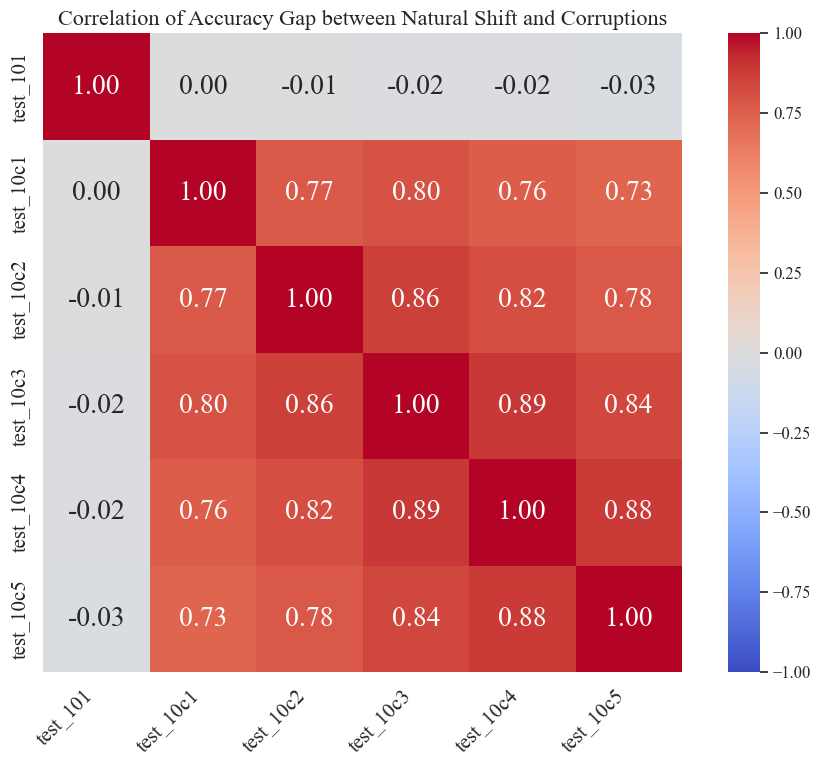

In [83]:
plot_correlation_matrix(
    performance_gap_df[[col for col in performance_gap_df.columns if "test" in col]],
    metric_prefix="accuracy",
    corr_type="kendall",
    title="Correlation of Accuracy Gap between Natural Shift and Corruptions",
    save_path=f"{IMAGES_DIR}/correlation_shift_corruptions_accuracy_gap.pdf",
)

Figure saved to reports/figures/correlation_shift_attacks_accuracy_gap.pdf


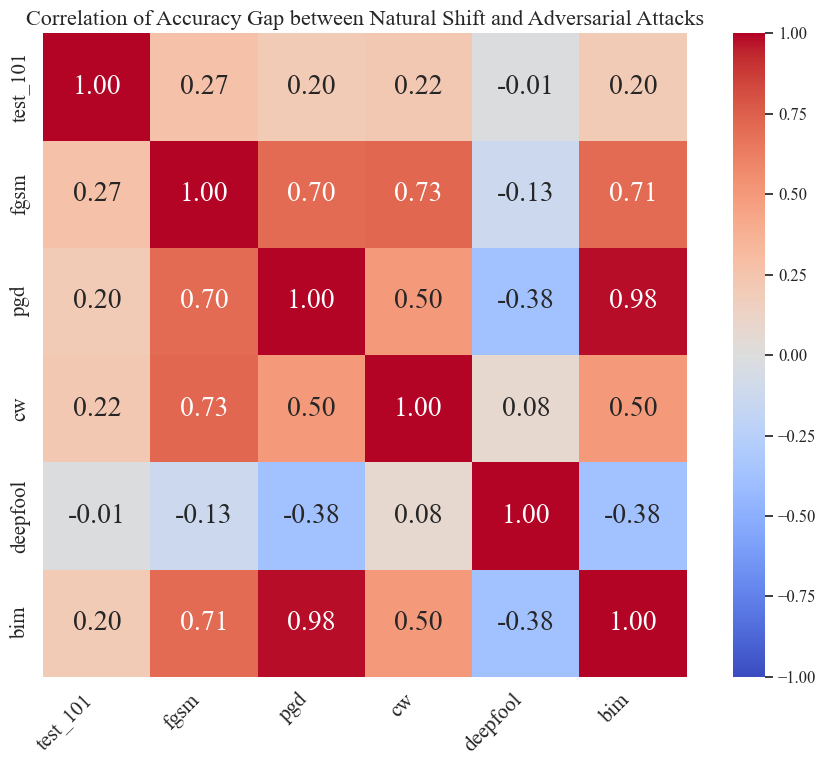

In [84]:
plot_correlation_matrix(
    performance_gap_df[[col for col in performance_gap_df.columns if "10c" not in col]],
    metric_prefix="accuracy",
    corr_type="kendall",
    title="Correlation of Accuracy Gap between Natural Shift and Adversarial Attacks",
    save_path=f"{IMAGES_DIR}/correlation_shift_attacks_accuracy_gap.pdf",
)

In [ ]:
cols = [col for col in performance_gap_df.columns if "accuracy" in col and "top5" not in col]
plot_pairplot(performance_gap_df[cols])

#### Log-Loss

In [ ]:
plot_correlation_matrix(
    performance_gap_df,
    metric_prefix="log_loss",
    corr_type="kendall",
    title="Log-Loss Correlation Matrix",
)

In [ ]:
cols = [col for col in performance_gap_df.columns if "log_loss" in col]
plot_pairplot(performance_gap_df[cols])

### 2.3 Multivariate - OOD Proportional Test Gap Values

#### Accuracy

In [ ]:
plot_correlation_matrix(
    proportional_performance_gap_df,
    metric_prefix="accuracy",
    corr_type="kendall",
    title="Accuracy Correlation Matrix",
)

In [ ]:
cols = [col for col in proportional_performance_gap_df.columns if "accuracy" in col and "top5" not in col]
plot_pairplot(proportional_performance_gap_df[cols])


#### Log-Loss

In [ ]:
plot_correlation_matrix(
    proportional_performance_gap_df,
    metric_prefix="log_loss",
    corr_type="kendall",
    title="Log-Loss Correlation Matrix",
)

In [ ]:
cols = [col for col in proportional_performance_gap_df.columns if "log_loss" in col]
plot_pairplot(proportional_performance_gap_df[cols])

# 3. Metric Analysis

###  3.1. Norm Measures

#### 3.1.1 OOD Test Gaps

Figure saved to reports/figures/correlation_norm_accuracy_gap.pdf


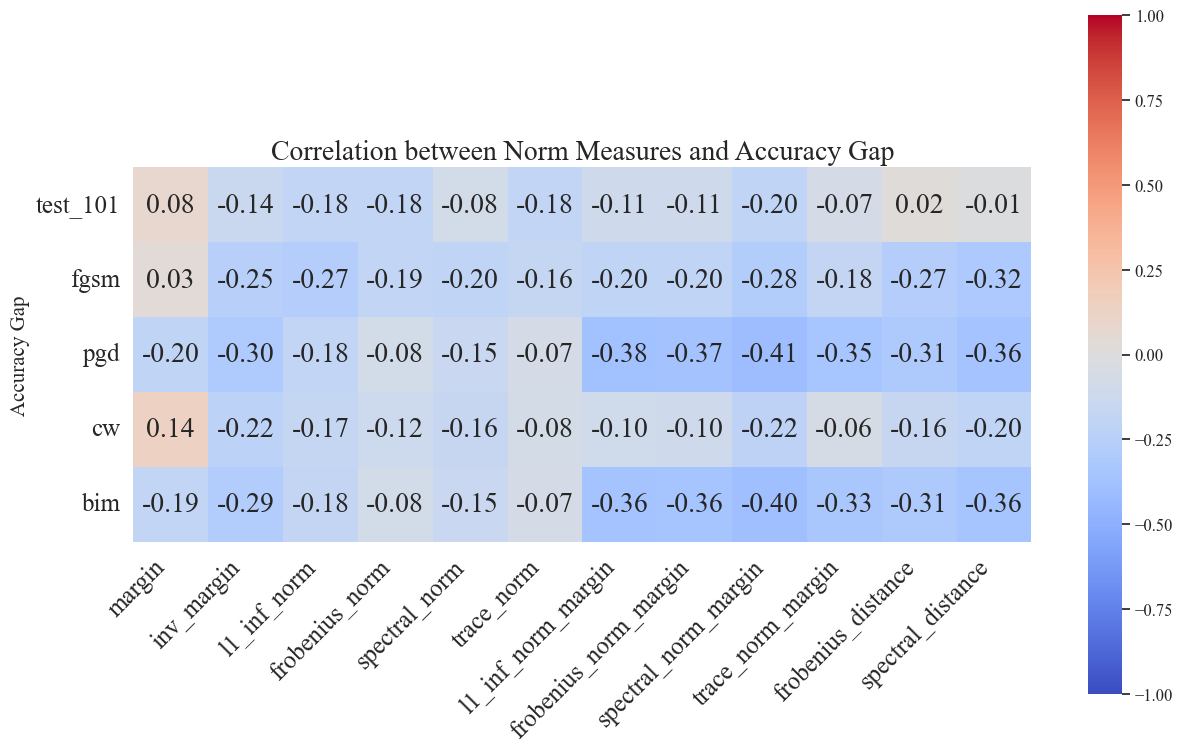

In [60]:
cols = [
    col
    for col in performance_gap_df.columns
    if "accuracy" in col and "top5" not in col and "10c" not in col and "deepfool" not in col
]
norms_cols = [
    col for col in norms_df.columns[:-7] if "squared" not in col and "log" not in col and "mu" not in col
]

dataframe_pairwise_correlation(
    performance_gap_df[cols].rename(columns=lambda x: x.replace("_accuracy_gap", "")),
    norms_df[norms_cols].drop("model_name", axis=1),
    x_label="Norm Measures",
    y_label="Accuracy Gap",
    method="kendall",
    title="Correlation between Norm Measures and Accuracy Gap",
    save_path=f"{IMAGES_DIR}/correlation_norm_accuracy_gap.pdf",
)

Figure saved to reports/figures/correlation_norm_log_loss_gap.pdf


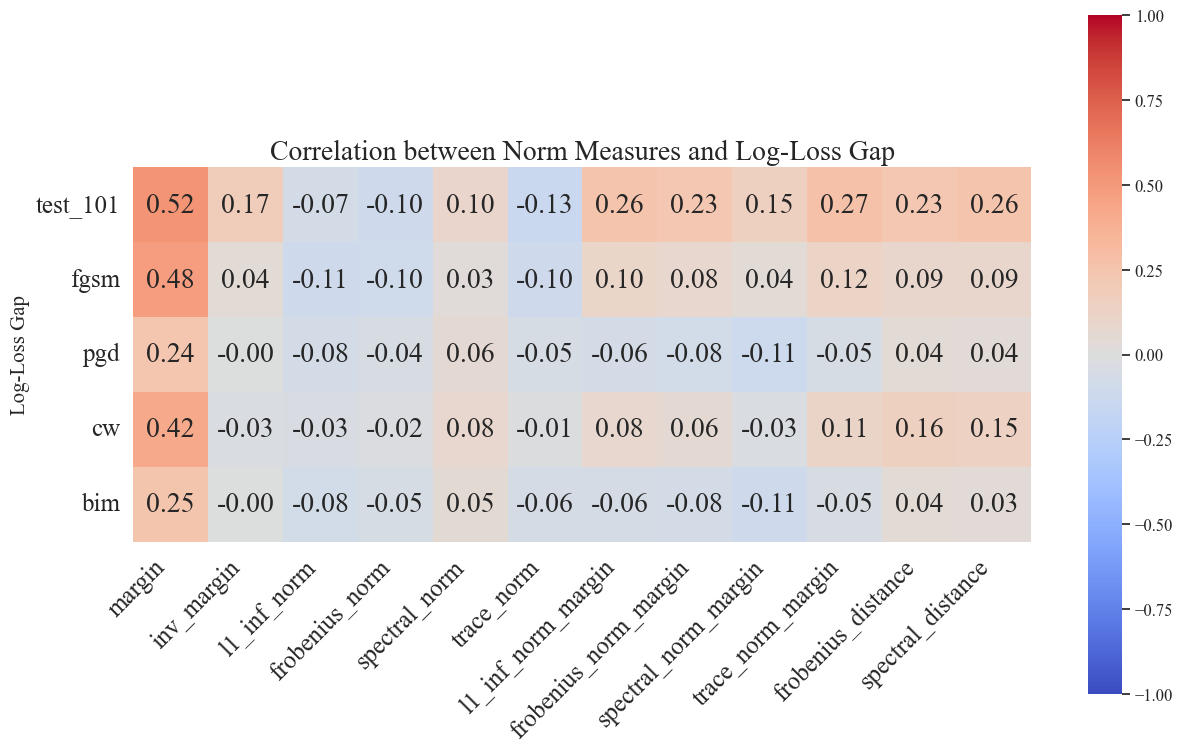

In [61]:
cols = [
    col
    for col in performance_gap_df.columns
    if "log_loss" in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    performance_gap_df[cols].rename(columns=lambda x: x.replace("_log_loss_gap", "")),
    norms_df[norms_cols].drop("model_name", axis=1),
    x_label="Norm Measures",
    y_label="Log-Loss Gap",
    method="kendall",
    title="Correlation between Norm Measures and Log-Loss Gap",
    save_path=f"{IMAGES_DIR}/correlation_norm_log_loss_gap.pdf",
)

#### 3.1.2 OOD Proportional Test Gaps

Figure saved to reports/figures/correlation_norm_proportional_accuracy_gap.pdf


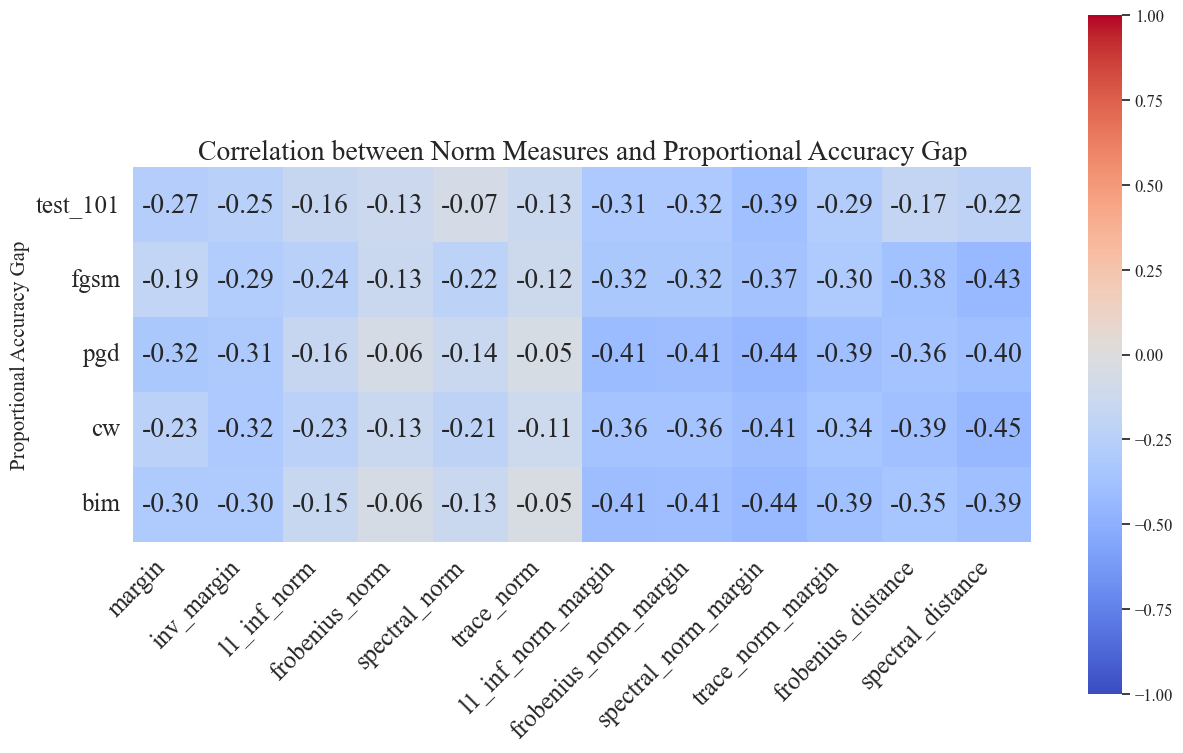

In [62]:
cols = [
    col
    for col in proportional_performance_gap_df.columns
    if "accuracy" in col and "top5" not in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    proportional_performance_gap_df[cols].rename(
        columns=lambda x: x.replace("_accuracy_proportional_gap", "")
    ),
    norms_df[norms_cols].drop("model_name", axis=1),
    x_label="Norm Measures",
    y_label="Proportional Accuracy Gap",
    method="kendall",
    title="Correlation between Norm Measures and Proportional Accuracy Gap",
    save_path=f"{IMAGES_DIR}/correlation_norm_proportional_accuracy_gap.pdf",
)

Figure saved to reports/figures/correlation_norm_proportional_log_loss_gap.pdf


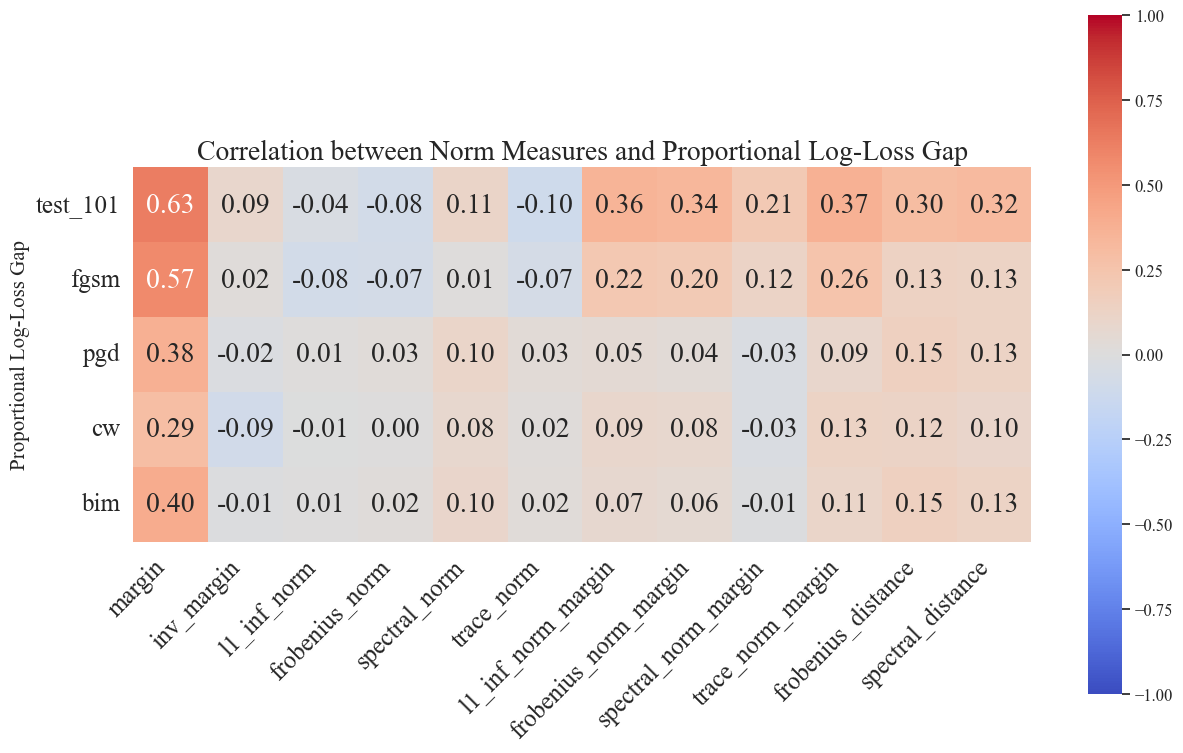

In [63]:
cols = [
    col
    for col in proportional_performance_gap_df.columns
    if "log_loss" in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    proportional_performance_gap_df[cols].rename(
        columns=lambda x: x.replace("_log_loss_proportional_gap", "")
    ),
    norms_df[norms_cols].drop("model_name", axis=1),
    x_label="Norm Measures",
    y_label="Proportional Log-Loss Gap",
    method="kendall",
    title="Correlation between Norm Measures and Proportional Log-Loss Gap",
    save_path=f"{IMAGES_DIR}/correlation_norm_proportional_log_loss_gap.pdf",
)

### 3.2. Correlation with Sharpness Measures

#### 3.2.1 OOD Test Gaps

Figure saved to reports/figures/correlation_sharpness_accuracy_gap.pdf


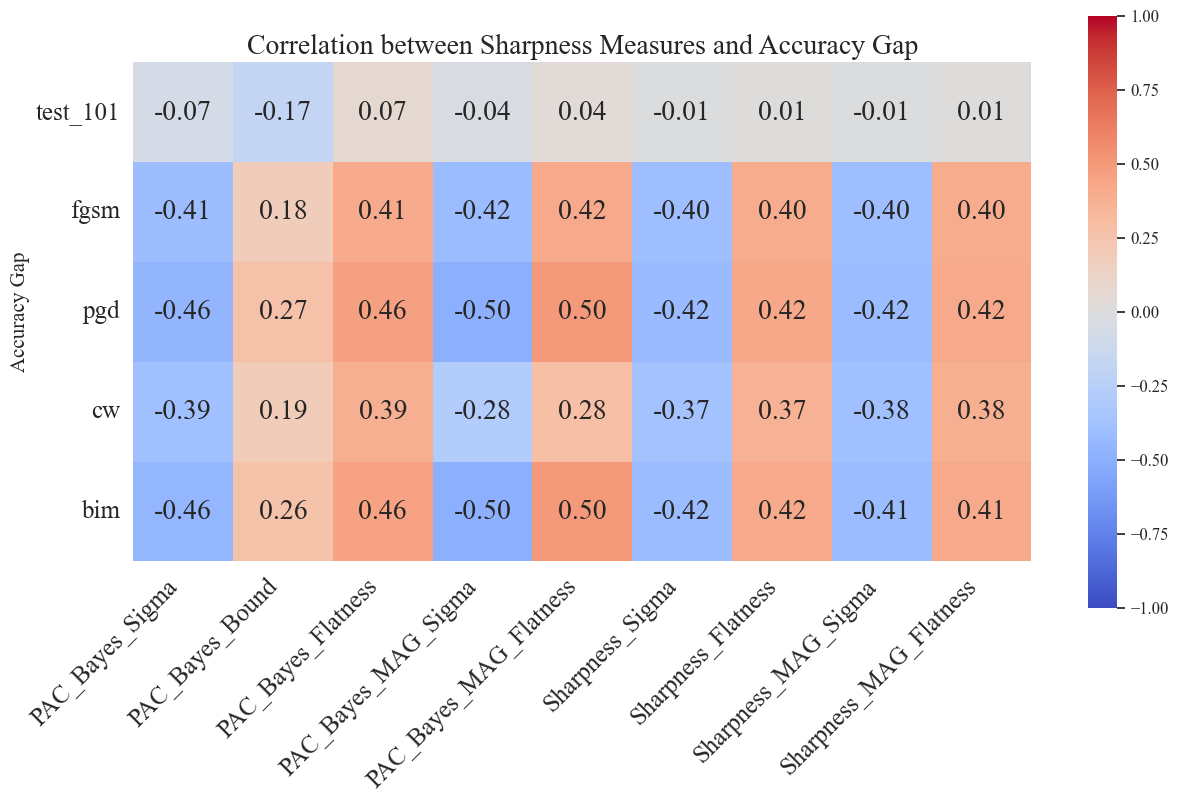

In [85]:
cols = [
    col
    for col in performance_gap_df.columns
    if "accuracy" in col and "top5" not in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    performance_gap_df[cols].rename(columns=lambda x: x.replace("_accuracy_gap", "")),
    sharpness_df.drop(
        ["model_name", "PAC_Bayes_MAG_Bound", "Sharpness_Bound", "Sharpness_MAG_Bound"], axis=1
    ),
    x_label="Sharpness Measures",
    y_label="Accuracy Gap",
    method="kendall",
    title="Correlation between Sharpness Measures and Accuracy Gap",
    save_path=f"{IMAGES_DIR}/correlation_sharpness_accuracy_gap.pdf",
)

Figure saved to reports/figures/correlation_sharpness_log_loss_gap.pdf


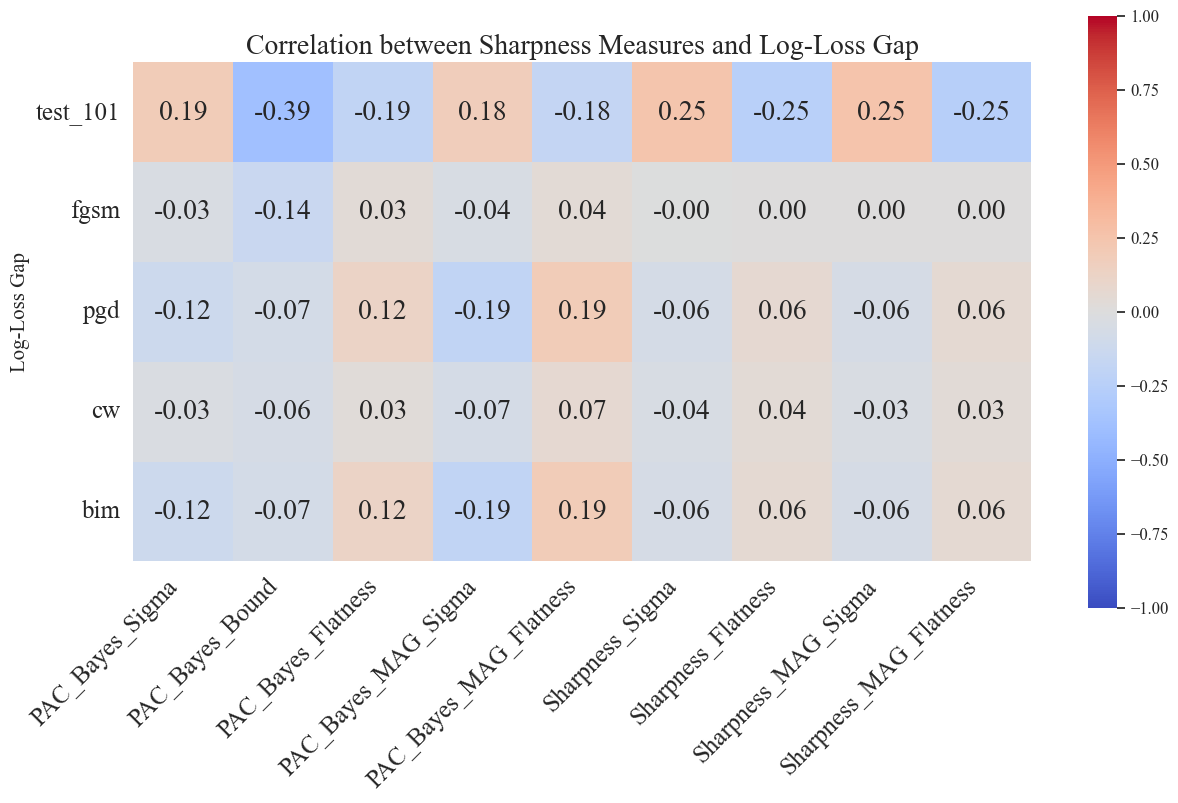

In [86]:
cols = [
    col
    for col in performance_gap_df.columns
    if "log_loss" in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    performance_gap_df[cols].rename(columns=lambda x: x.replace("_log_loss_gap", "")),
    sharpness_df.drop(
        ["model_name", "PAC_Bayes_MAG_Bound", "Sharpness_Bound", "Sharpness_MAG_Bound"], axis=1
    ),
    x_label="Sharpness Measures",
    y_label="Log-Loss Gap",
    method="kendall",
    title="Correlation between Sharpness Measures and Log-Loss Gap",
    save_path=f"{IMAGES_DIR}/correlation_sharpness_log_loss_gap.pdf",
)

#### 3.2.2 OOD Proportional Test Gaps

Figure saved to reports/figures/correlation_sharpness_proportional_accuracy_gap.pdf


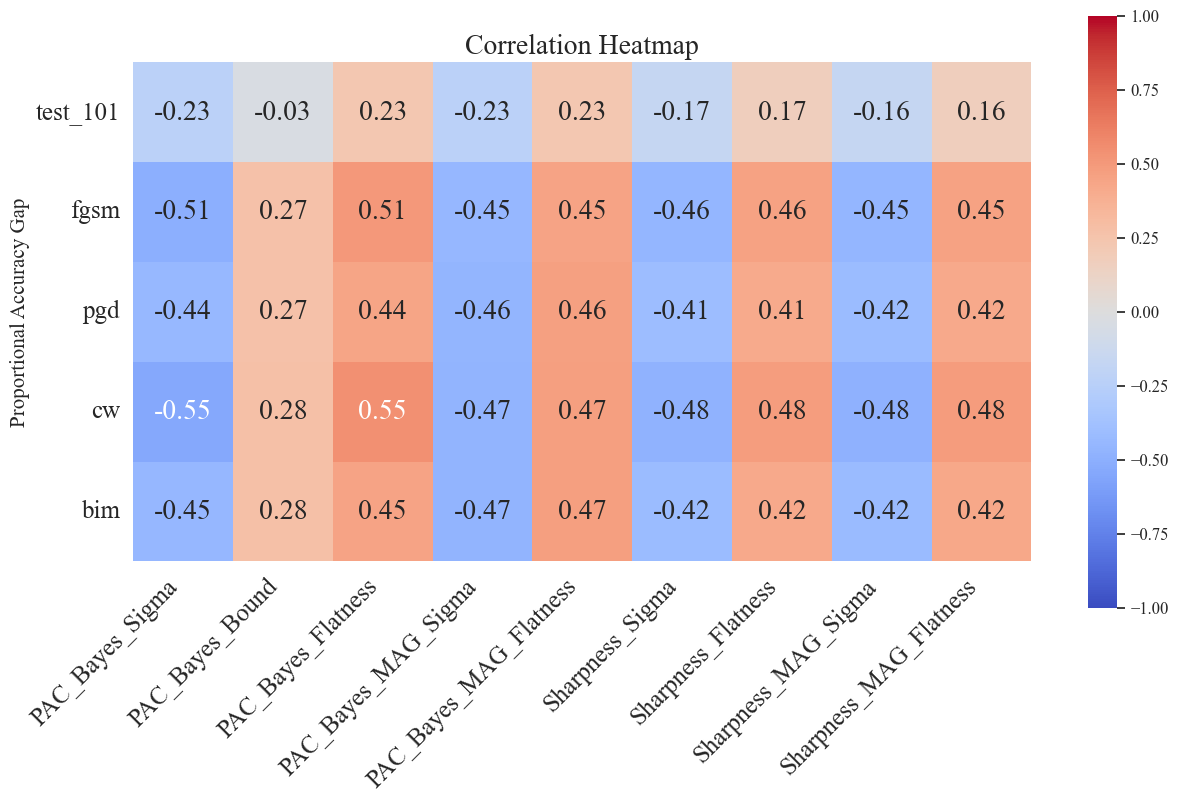

In [87]:
cols = [
    col
    for col in proportional_performance_gap_df.columns
    if "accuracy" in col and "top5" not in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    proportional_performance_gap_df[cols].rename(
        columns=lambda x: x.replace("_accuracy_proportional_gap", "")
    ),
    sharpness_df.drop(
        ["model_name", "PAC_Bayes_MAG_Bound", "Sharpness_Bound", "Sharpness_MAG_Bound"], axis=1
    ),
    x_label="Sharpness Measures",
    y_label="Proportional Accuracy Gap",
    method="kendall",
    save_path=f"{IMAGES_DIR}/correlation_sharpness_proportional_accuracy_gap.pdf",
)

Figure saved to reports/figures/correlation_sharpness_proportional_log_loss_gap.pdf


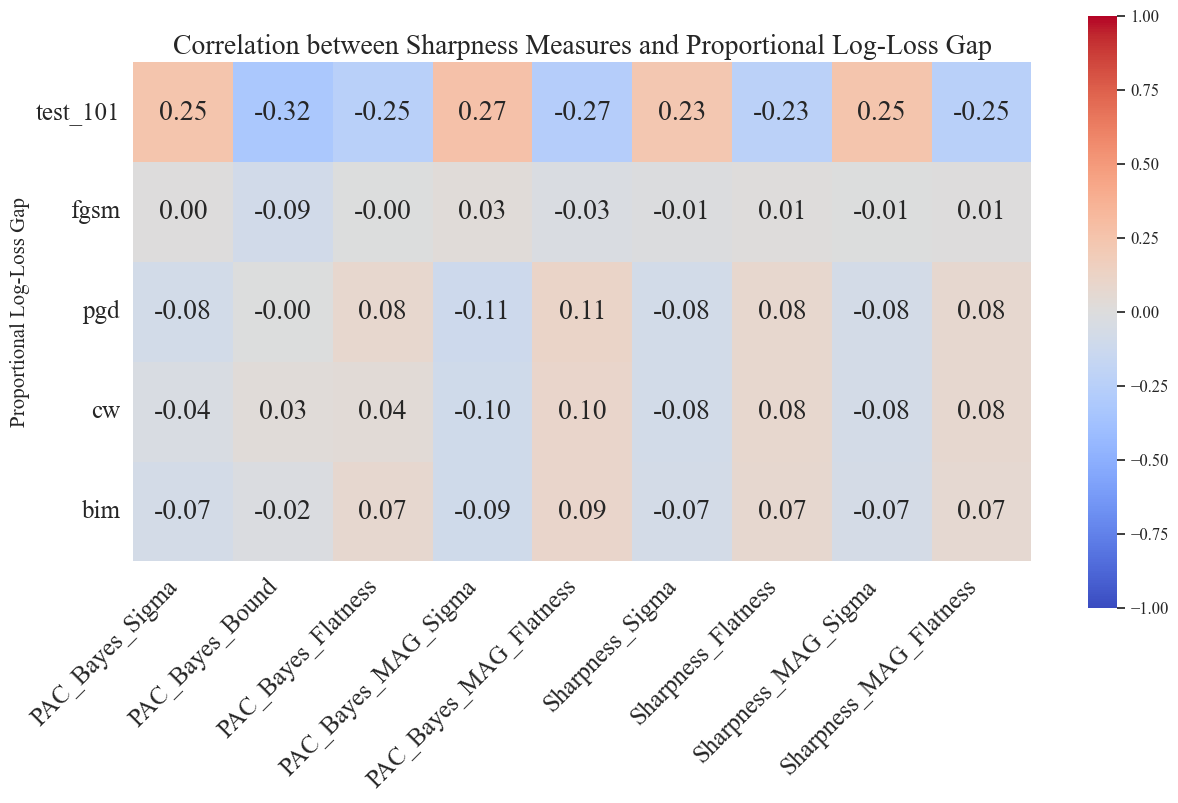

In [88]:
cols = [
    col
    for col in proportional_performance_gap_df.columns
    if "log_loss" in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    proportional_performance_gap_df[cols].rename(
        columns=lambda x: x.replace("_log_loss_proportional_gap", "")
    ),
    sharpness_df.drop(
        ["model_name", "PAC_Bayes_MAG_Bound", "Sharpness_Bound", "Sharpness_MAG_Bound"], axis=1
    ),
    x_label="Sharpness Measures",
    y_label="Proportional Log-Loss Gap",
    method="kendall",
    title="Correlation between Sharpness Measures and Proportional Log-Loss Gap",
    save_path=f"{IMAGES_DIR}/correlation_sharpness_proportional_log_loss_gap.pdf",
)

### 3.4. Correlation with Performance Measures


#### 3.4.1 OOD Test Gaps


Figure saved to reports/figures/correlation_performance_accuracy_gap.pdf


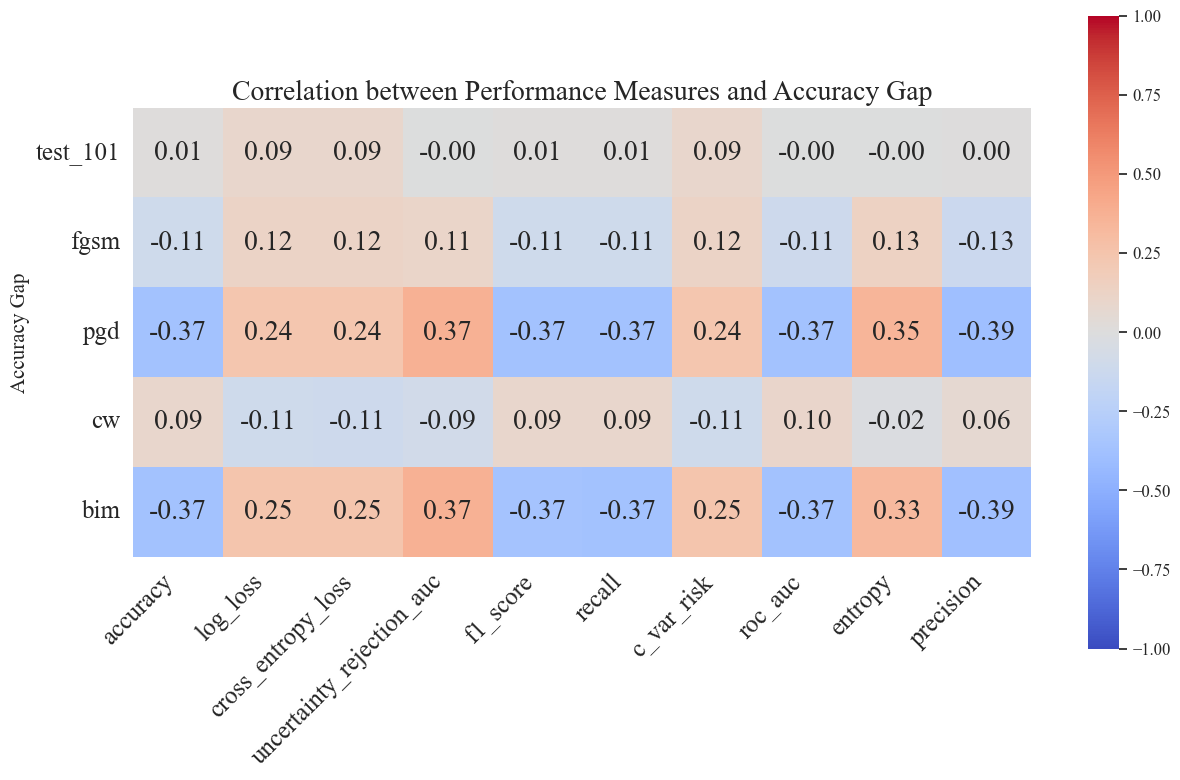

In [68]:
cols = [
    col
    for col in performance_gap_df.columns
    if "accuracy" in col and "top5" not in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    performance_gap_df[cols].rename(columns=lambda x: x.replace("_accuracy_gap", "")),
    performance_df[[col for col in performance_df if "model_name" not in col and "top5" not in col]],
    x_label="Performance Measures",
    y_label="Accuracy Gap",
    title="Correlation between Performance Measures and Accuracy Gap",
    method="kendall",
    save_path=f"{IMAGES_DIR}/correlation_performance_accuracy_gap.pdf",
)

Figure saved to reports/figures/correlation_performance_log_loss_gap.pdf


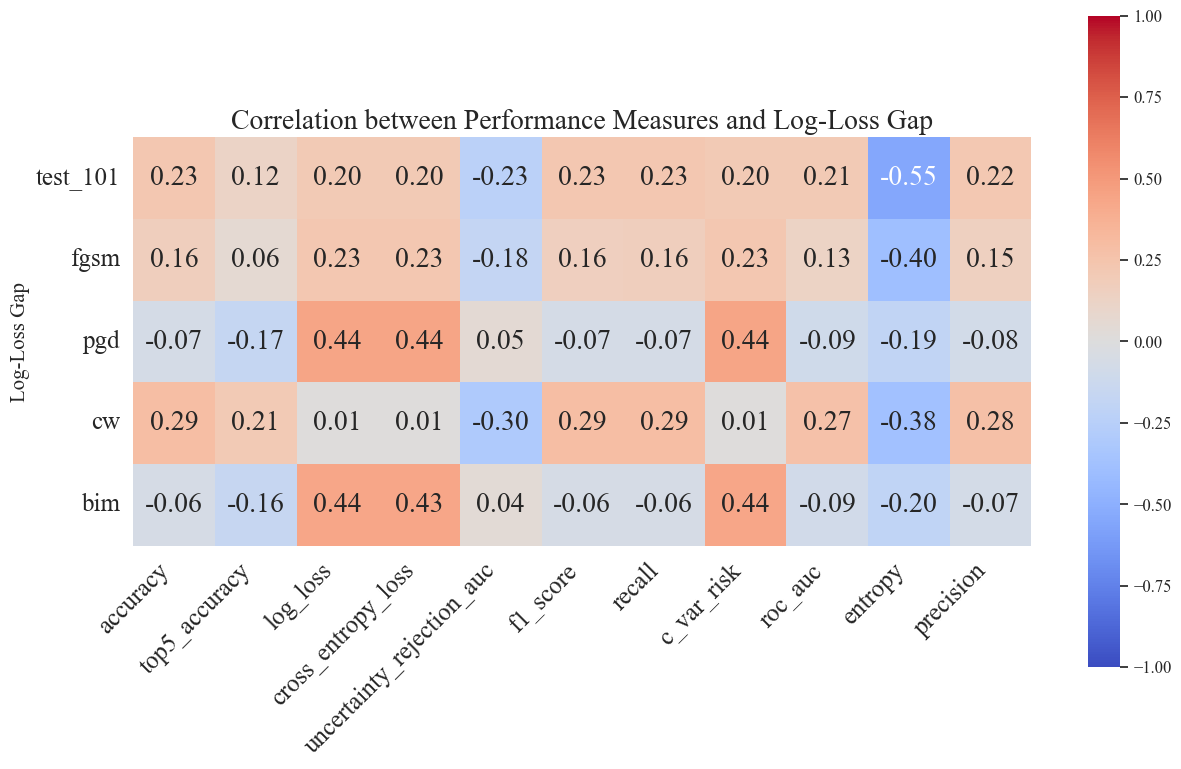

In [69]:
cols = [
    col
    for col in performance_gap_df.columns
    if "log_loss" in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    performance_gap_df[cols].rename(columns=lambda x: x.replace("_log_loss_gap", "")),
    performance_df.drop("model_name", axis=1),
    x_label="Performance Measures",
    y_label="Log-Loss Gap",
    title="Correlation between Performance Measures and Log-Loss Gap",
    method="kendall",
    save_path=f"{IMAGES_DIR}/correlation_performance_log_loss_gap.pdf",
)


#### 3.4.2 OOD Proportional Test Gaps


Figure saved to reports/figures/correlation_performance_proportional_accuracy_gap.pdf


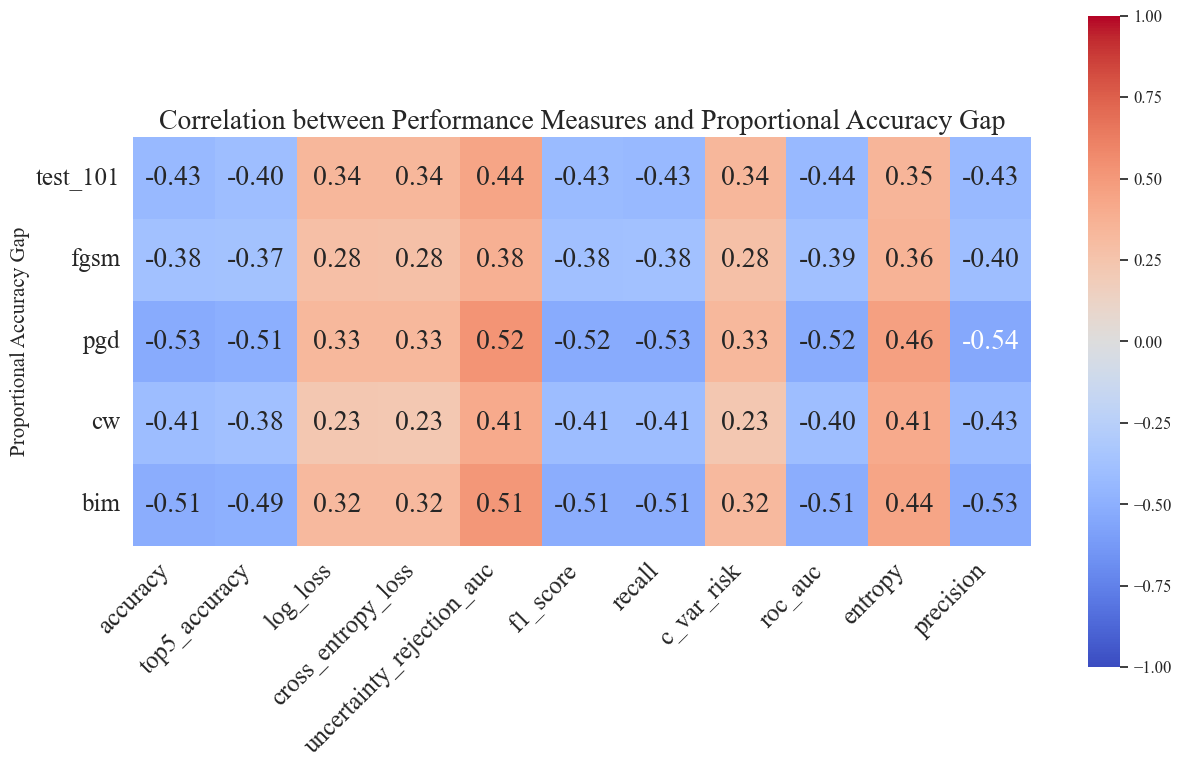

In [70]:
cols = [
    col
    for col in proportional_performance_gap_df.columns
    if "accuracy" in col and "top5" not in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    proportional_performance_gap_df[cols].rename(
        columns=lambda x: x.replace("_accuracy_proportional_gap", "")
    ),
    performance_df.drop("model_name", axis=1),
    x_label="Performance Measures",
    y_label="Proportional Accuracy Gap",
    title="Correlation between Performance Measures and Proportional Accuracy Gap",
    method="kendall",
    save_path=f"{IMAGES_DIR}/correlation_performance_proportional_accuracy_gap.pdf",
)

Figure saved to reports/figures/correlation_performance_proportional_log_loss_gap.pdf


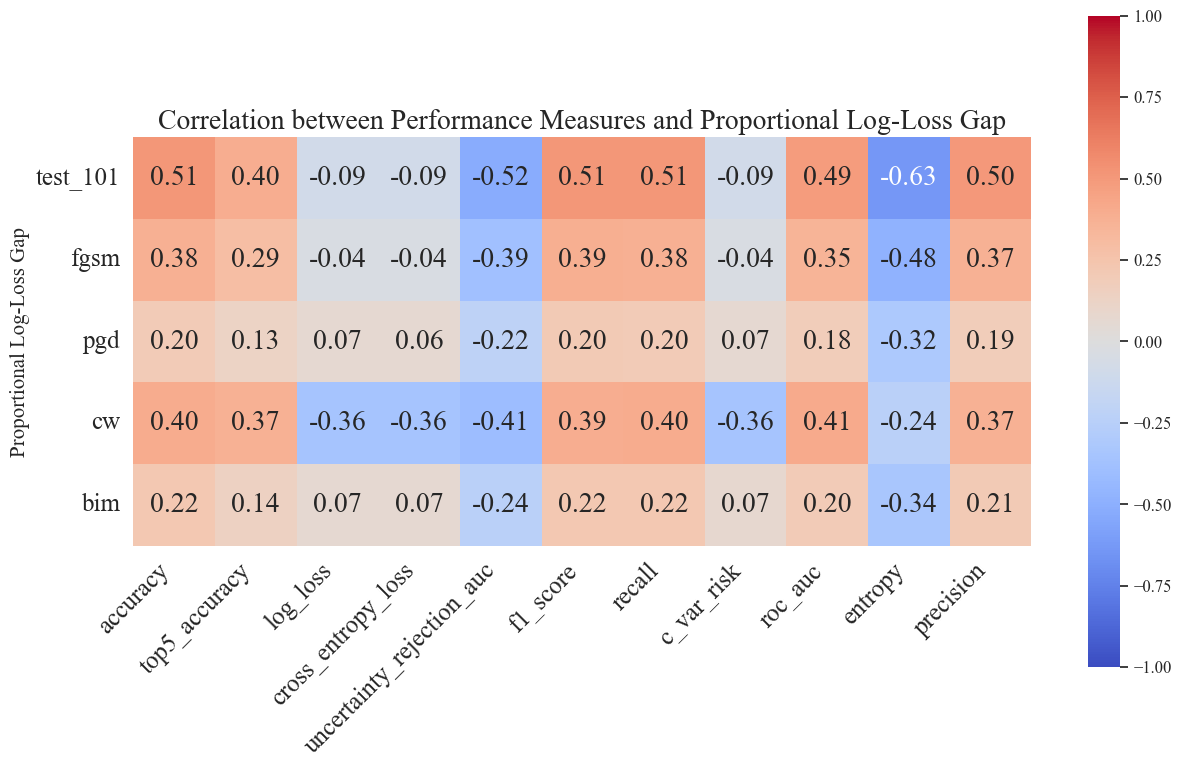

In [ ]:
cols = [
    col
    for col in proportional_performance_gap_df.columns
    if "log_loss" in col and "10c" not in col and "deepfool" not in col
]
dataframe_pairwise_correlation(
    proportional_performance_gap_df[cols].rename(
        columns=lambda x: x.replace("_log_loss_proportional_gap", "")
    ),
    performance_df.drop("model_name", axis=1),
    method="kendall",
    x_label="Performance Measures",
    y_label="Proportional Log-Loss Gap",
    title="Correlation between Performance Measures and Proportional Log-Loss Gap",
    save_path=f"{IMAGES_DIR}/correlation_performance_proportional_log_loss_gap.pdf",
)
